# Численное интегрирование

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

# VII.9.5

### Входные данные

Функция из пункта а) VII.9.5. Не вводил из таблицы, чтобы можно было поиграть с шагом.

$$f(x) = \frac{\sin{x}}{x}, \;\;x_i = 0, 0.25, ..., 2.0$$

In [236]:
step = 0.25
x = np.arange(0, 2 + step, step, dtype=np.float64)

import warnings
with warnings.catch_warnings():
    # Я знаю, что делим на ноль
    warnings.simplefilter("ignore")
    f = np.sin(x) / x
    f[0] = 1

pd.DataFrame({'f' : f, 'x' : x})

,f,x
0,1.000000,0.00
1,0.989616,0.25
2,0.958851,0.50
3,0.908852,0.75
4,0.841471,1.00
5,0.759188,1.25
6,0.664997,1.50
7,0.562278,1.75
8,0.454649,2.00


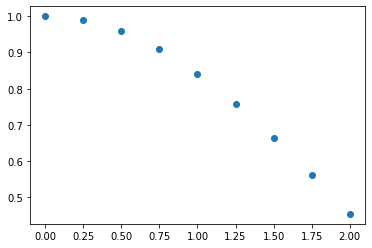

In [237]:
plt.scatter(x, f)

### Метод трапеций

In [238]:
def trapezoidal(x, f):
    assert len(x) == len(f), 'Arrays must have the same length'
    __I = 0
    for i in range(len(x) - 1):
        __I = __I + (x[i+1] - x[i]) / 2 * (f[i+1] + f[i])
    return __I

trapezoidal(x, f)

1.603143993230099

### Экстраполяция Ричардсона

In [239]:
def richardson(x, f, I, p):
    assert len(x) == len(f), 'Arrays must have the same length'
    return I(x, f) + (I(x, f) - I(x[::2], f[::2])) / (2**p - 1)

richardson(x, f, trapezoidal, 2)

1.6054181448970055

### Метод Симпсона

In [240]:
def simpson(x, f):
    assert len(x) == len(f), 'Arrays must have the same length'
    __I = 0
    for i in range(len(x) // 2):
        __I = __I + (x[2*i+1] - x[2*i]) / 3 * (f[2*i] + 4*f[2*i+1] + f[2*i+2])
    return __I

simpson(x, f)

1.6054181448970055

### Интегрируем

In [241]:
from scipy import integrate
print(f"Trapezoidal             : {trapezoidal(x, f)}")
print(f"Ref. Trapezoidal        : {np.trapz(x=x, y=f)}")
print(f"Simpson                 : {simpson(x, f)}")
print(f"Ref. Simpson            : {integrate.simpson(x=x, y=f)}")
print(f"Richardson (Trapezoidal): {richardson(x, f, trapezoidal, 2)}")
print(f"Richardson (Simpson)    : {richardson(x, f, simpson, 4)}")
print(f"Wolfram                 : {1.6054129768026948485767201481985889408486}")

Trapezoidal             : 1.603143993230099
Ref. Trapezoidal        : 1.603143993230099
Simpson                 : 1.6054181448970055
Ref. Simpson            : 1.6054181448970055
Richardson (Trapezoidal): 1.6054181448970055
Richardson (Simpson)    : 1.6054128920811792
Wolfram                 : 1.6054129768026948


# VII.9.13.

### Входные данные
Пункт а) VII.9.13

In [242]:
x_i = np.array([0,       1,       2,       3,       4      ], dtype=np.float64)
f_i = np.array([0.00000, 0.50000, 0.86603, 1.00000, 0.86603], dtype=np.float64)
k = 50

pd.DataFrame({'f' : f, 'x' : x})

,f,x
0,1.000000,0.00
1,0.989616,0.25
2,0.958851,0.50
3,0.908852,0.75
4,0.841471,1.00
5,0.759188,1.25
6,0.664997,1.50
7,0.562278,1.75
8,0.454649,2.00


### Сплайн интерполяция
В основном код взят из предыдущей лабы. Но заменены граничные условия.

`см. Lab 4 - Interpolation/interpolation.ipynb`

#### Метод трехдиагональной прогонки

In [243]:
#
# Tridiagonal matrix algorithm
# See: https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
#
# [b c 0     ... 0][x0]     [d0]
# [a b c 0   ... 0][x1]     [d1]
# [0 a b c 0 ... 0][x2]   = [d2]
# [      ...      ][...]    [...]
# [0     ... 0 a b][xn-1]   [dn-1]
#
def tridiagonal(a, b, c, d):
    assert len(a) + 1 == len(b) == len(c) + 1 == len(d), 'Arrays lengths mismatch'
     
    __a = np.array(a, dtype = np.float64)
    __b = np.array(b, dtype = np.float64)
    __c = np.array(c, dtype = np.float64)
    __d = np.array(d, dtype = np.float64)
    
    for i in range(1, len(__d)):
        __w = __a[i - 1] / __b[i - 1]
        __b[i] = __b[i] - __w * __c[i - 1]
        __d[i] = __d[i] - __w * __d[i - 1]

    __x = np.empty(len(__d), dtype = np.float64)
    __x[-1] = __d[-1] / __b[-1]
    for i in range(len(__d) - 2, -1, -1):
        __x[i] = (__d[i] - __c[i] * __x[i + 1]) / __b[i]

    # Test solution
    __test_matrix = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
    assert np.max(abs((np.matmul(__test_matrix, __x.T) - d))) < 1e-6, 'Tridiagonal method failed'
        
    return __x

In [244]:
def divided_diff(i, x, f):
    assert len(i) >= 1, 'Index array must not be empty'
    assert len(x) == len(f) == len(i), 'Arrays lengths mismatch'
    if len(i) == 1:
        return f[0]
    # Обобщим разность для одинаковых узлов
    if x[-1] == x[0]:
        return 0
    
    return (divided_diff(i[1:], x[1:], f[1:]) - divided_diff(i[:-1], x[:-1], f[:-1])) / (x[-1] - x[0])

#
# Cubic Spline interpolation
# See: https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation
#
class Spline:
    def __init__(self, x, f):
        assert len(x) == len(f), 'Arrays lengths mismatch'
        
        self.x = x
        self.f = f
        
        __diag = np.full(len(self.x), 2)
        __mu = np.empty(len(self.x) - 1)
        __mu.fill(0)
        for i in range(0, len(self.x) - 2):
            __mu[i] = (self.x[i+1] - self.x[i])/(self.x[i+2] - self.x[i])
        __mu[-1] = 0 # Boundary conditions

        __lambda = np.empty(len(self.x) - 1)
        __lambda.fill(0)
        __lambda[1:] = 1 - __mu[:-1]
        __lambda[0] = 0 # Boundary conditions
        
        __d = np.empty(len(self.x))
        for i in range(0, len(self.x)):
            jj = (max(0, i - 1), i, min(len(self.x) - 1, i + 1))
            __d[i] = 6 * divided_diff(jj, np.take(self.x, jj), np.take(self.f, jj))
        
        # WARNING! Boundary conditions were changed!
        __d[0] = __d[-1] = 0 # Simple Boundary conditions
        
        self.M = tridiagonal(__mu, __diag, __lambda, __d)
        
    def __call__(self, x_arr):      
        __res = np.empty(len(x_arr))
        for j, x in enumerate(x_arr):
            i = np.argmax(self.x > x)
            hi = (self.x[i] - self.x[i-1])
            __res[j] = self.M[i-1] * (self.x[i] - x)**3 / (6 * hi) \
                       + self.M[i] * (x - self.x[i-1])**3 / (6 * hi) \
                       + (self.f[i-1] - self.M[i-1] * hi**2 / 6) * (self.x[i] - x) / hi \
                       + (self.f[i] - self.M[i] * hi**2 / 6) * (x - self.x[i-1]) / hi
        return __res

### Интерполяция входных данных

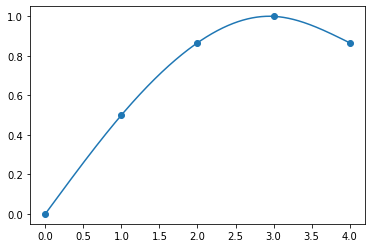

In [245]:
interp = Spline(x_i, f_i)
t = np.linspace(min(x_i), max(x_i), 1001)
plt.plot(t, interp(t))
plt.scatter(x_i, f_i)

### Интегрируем

Trapezoidal             : -0.00834310288956949
Ref. Trapezoidal        : -0.008343102889569486
Simpson                 : -0.008371550261538808
Ref. Simpson            : -0.008371550261538786
Richardson (Trapezoidal): -0.008371550261538784
Richardson (Simpson)    : -0.008371471880800346


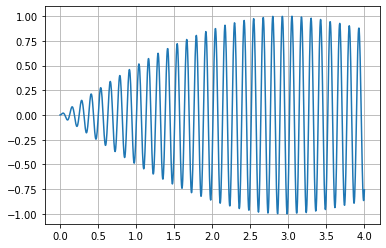

In [246]:
x = t
f = np.sin(k * x) * interp(x)

plt.plot(x, f)
plt.grid()

from scipy import integrate
print(f"Trapezoidal             : {trapezoidal(x, f)}")
print(f"Ref. Trapezoidal        : {np.trapz(x=x, y=f)}")
print(f"Simpson                 : {simpson(x, f)}")
print(f"Ref. Simpson            : {integrate.simpson(x=x, y=f)}")
print(f"Richardson (Trapezoidal): {richardson(x, f, trapezoidal, 2)}")
print(f"Richardson (Simpson)    : {richardson(x, f, simpson, 4)}")